We'll be using differential dynamic microscopy. This technique was first described in 2008 in an article in PRL by Cerbino and Trappe. 
![PRL image](DDM_Paper_PRL.PNG)
You can find the paper [here](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.188102). 

The heart of the DDM code (found in the `ddm_clean.py` file) is the computation of the image structure function. This is found by taking the average of the Fourier transforms of all image *differences*. By "image differences," I mean the result of subtracting two images separated by a given lag time $\Delta t$.

To describe the process mathematically, we find the difference between images separated by some lag time $\Delta t$:
$$\Delta I = I(x,y;t) - I(x,y;t + \Delta t)$$

For a given $\Delta t$ all such image differences are calculated. We then Fourier transform each $\Delta I$ and average all of the same $\Delta t$.

This results in the image structure function $D(q_x,q_y,\Delta t)$.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import mpld3

# Use seaborn styles for nice-looking plots
#import seaborn; seaborn.set()

In [4]:
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }

C:\Users\Physics\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
import numpy as np #numerical python used for working with arrays, mathematical operations
import time #useful for timing functions
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

tiff_file.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
tiff_file.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


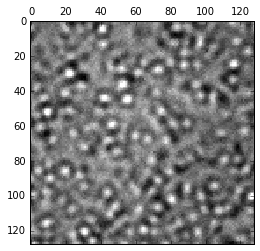

In [6]:
#Specify where the data is stored and the image data filename. Must be in tiff format
data_dir = ".\\ExampleData\\"
data_file = "images_nobin_40x_128x128_8bit.tif"

#Image read using tiff_file module
im = ddm.tiff_file.imread(data_dir+data_file)

#Display the second frame of the image
plt.matshow(im[1], cmap=matplotlib.cm.gray)

------------------------------------------------------
In the cell below, we generate the list of delay times. We will calculate the image structure function for only these set of lag times. 

We are also constructing a filter to multiply the images by. This filter is used to remove artifacts that might appear in the image structure function to the edges of the images. To reduce potential artifacts from the boundaries, we use a Blackman-Harris windowing function. This method was described in the [paper found here](https://arxiv.org/abs/1707.07501). 

In [7]:
numPixels = im.shape[1]
x,y = np.meshgrid(bh(numPixels),bh(numPixels))
filter_func = x*y
num_pts = 30 #usually num_pts was 400 when we have done data analysis
dts = ddm.genLogDist(1,998,num_pts) 

The cell below will calculate the image structure function. The main function is the `ddm.getFFTDiffsAtTimes`. That function returns the averaged Fourier tranforms of all differences between images separated by the lag times in the list `dts`. 

Those image structure functions are then radially averaged with `ddm.radialAvFFTs_v2`. We can radially average when we know that the dynamics are isotropic. 

The data is then stored in a [dictionary](https://docs.python.org/2/tutorial/datastructures.html?highlight=dictionary#dictionaries) and saved to a file using the [`pickle` function](https://docs.python.org/2/library/pickle.html). 

In [8]:
fft,dtsB = ddm.getFFTDiffsAtTimes(im[1:,0:numPixels,0:numPixels]*filter_func, dts, every=None, limitImsTo=None, submean=True)
ravs = ddm.radialAvFFTs_v2(fft)
dts_fft = {'dts':dts, 'ffts':fft, 'ravs':ravs}
f=open(data_dir + data_file[:-4]+"_1_BH_128x128_FFTDIFFS_dts_ravs.p",'wb')
pickle.dump(dts_fft, f)
f.close()

Running dt=15...



---------------------------------
Since the `getFFTDiffsAtTimes` function can take several minutes (or even hours) to run if the images are large and if we find the image structure function at many lag times, it is best to always save the output to that function. That way, if you want to come back and do more analysis, you just load the saved image structure functions. Loading that saved file is done with the function `pickle.load`.

In [9]:
f = open(data_dir + data_file[:-4]+"_1_BH_128x128_FFTDIFFS_dts_ravs.p",'rb')
p_data = pickle.load(f)
f.close()
p_data.keys()

['dts', 'ravs', 'ffts']

In [10]:
#This is how data is stored in dictionaries
ravs = p_data['ravs']
dts = p_data['dts']

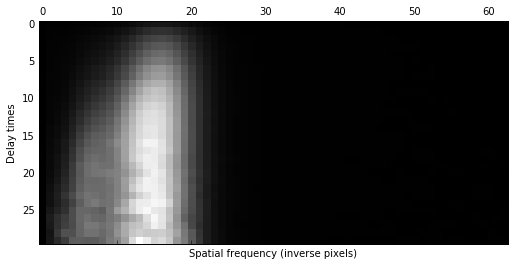

In [11]:
plt.matshow(ravs, cmap=matplotlib.cm.gray)
plt.xlabel("Spatial frequency (inverse pixels)")
plt.ylabel("Delay times");

In [12]:
fps = 41.7 #The frame rate the video data was recorded at
times = dts/fps #Create the list of delay times in units of seconds
q = np.arange(0,64)*2*np.pi*(1./(128*0.242)) #Convert the spatial frequencies to wave vectors

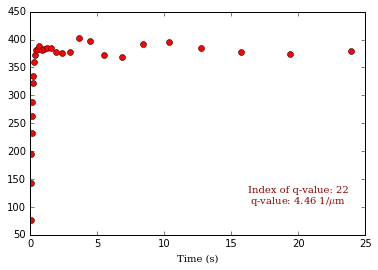

In [13]:
##########################################################################
# Here, we'll show the image structure function for a particular q-value. 
##########################################################################

qv=22
plt.plot(times, ravs[:,qv],'ro')
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % qv, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.text(0.8, 0.15, 'q-value: %.2f 1/$\mu$m' % q[qv], horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)', fontdict=font_plt_ax);


--------------------------------------------------------------------------------------
Now we need to fit the image structure functions for each q-value. 

Finding the appropriate fitting function is not always straightforward. When analyzing DDM data, this fitting step is often the most time consuming and potentially frustrating. 

We will try to fit the data using the Levenberg-Marquardt least-squares minimization method implemented in the `mpfit` module. We will also use SciPy's ['leastsq' function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html). 

Both functions seem to do an okay job. One nice feature of the `mpfit` module is that you can specify the minimum and maximum values that each parameter is allowed to take. You can also easily change parameters from ones that are allowed to vary to ones that are fixed. 

One important task when doing the fitting is to come up with good initial guesses. That is what the `ddm.returnReasonableParams` tries to do in an automated fashion. However, you may need to adjust the initial guesses by hand. 

For the Levenberg-Marquardt function, in addition to giving the optimization function the best guess parameters, you give it the minimum values those parameters can take, the maximum values those paramters can take, and a Boolean array specifying whether the parameters are fixed or not. 

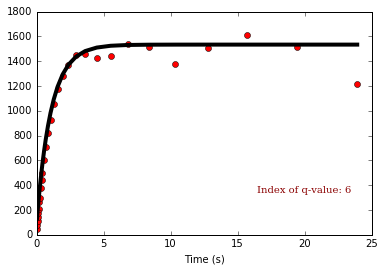

In [84]:
q_index = 6

#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function
pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index], double=False, fps=fps)
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

C:\Users\Physics\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


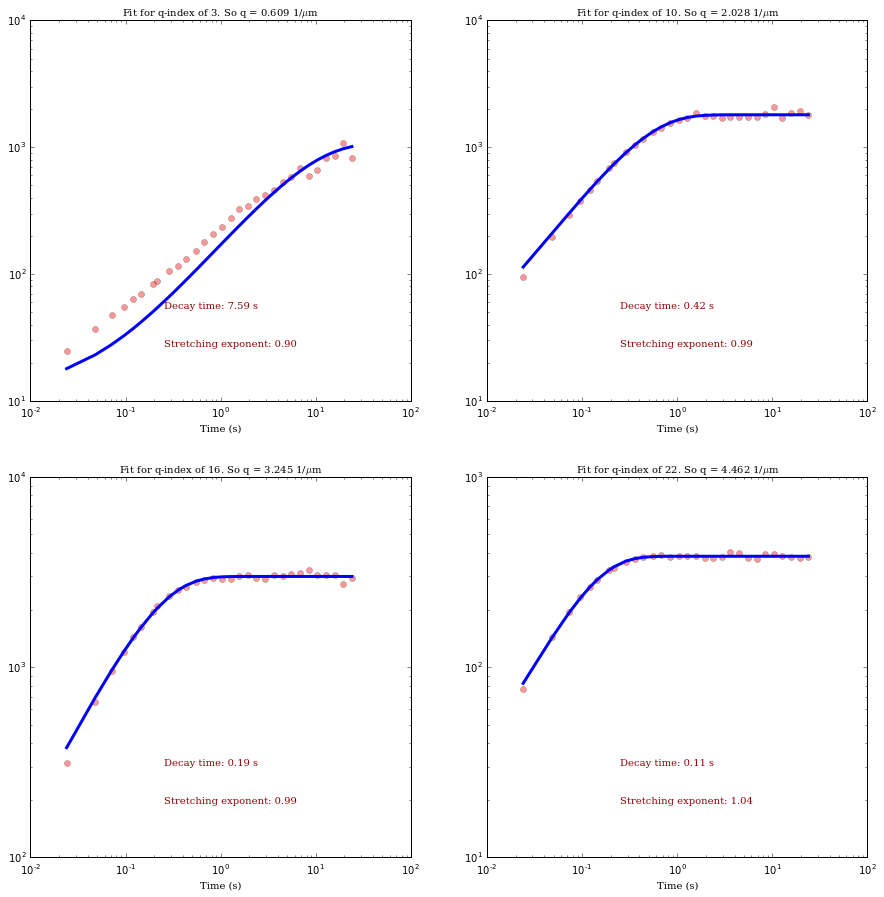

In [15]:
def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''
    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=12, double=False, fps=1./times[0])
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp), (... same for second exp..))
    
    minp[3]=0.9
    maxp[3]=1.05
    maxp[2]=1e14
    pars[3]=1.00
    fix[2]=True
    fix[3]=False

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

plt.figure(figsize=(15,15)) #Create figure of size 15x15 (inches)

#Loop over four different q-values to do the fit
for i,q_index in enumerate([3,10,16,22]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:,q_index], times)
    ax = plt.subplot(2,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.loglog(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times, theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.15,'Stretching exponent: %.2f' % fitparamsB[3], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)

In [16]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
for i in range(1,len(tau)):
    fitparams, theory, chi2 = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[0]
    bg[i] = fitparams[2]
    tau[i] = fitparams[1]
    alph[i] = fitparams[3]

ddm_clean.py:243: RuntimeWarning: invalid value encountered in power
  g1 = np.exp(-1 * (x / t1)**s1)
C:\Users\Physics\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


--------------------
You now will want to inspect the discovered fit parameters. You may need to adjust things (maybe fix certain parameters or allow others, like the background, to vary). 

Often, the parameter we are most interested in is the `tau` parameter -- the decay time. 

For normal diffusive dynamics, we expect that the decay time is inversely proportional to the wave vector squared. The constant of proportionality is 1/D where D is the diffusion coefficient. So we will plot the decay time versus q on a log-log plot. If the dynamics follow normal diffusion, then we should see that the data follows a straight line with a slope of -2. 

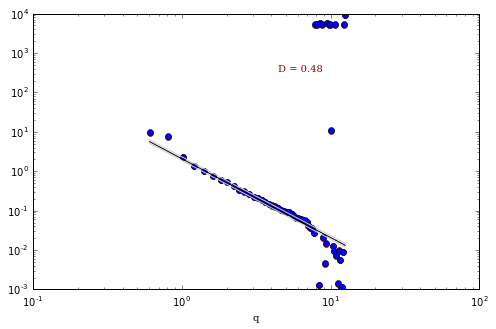

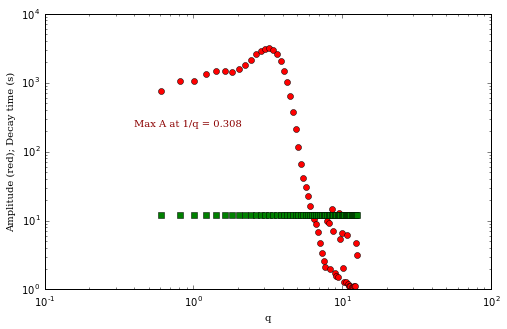

In [17]:
%matplotlib inline
mpld3.enable_notebook()

#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')
diffusion_coeff = 0.48
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
diffusion_coeff_2 = 0.53
ax.plot(q[3:-1], (1./diffusion_coeff_2) * 1./(q[3:-1]**2), '-', c='0.8')
diffusion_coeff_3 = 0.43
ax.plot(q[3:-1], (1./diffusion_coeff_3) * 1./(q[3:-1]**2), '-', c='0.8')
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.text(0.55,0.8,'D = %.2f' % diffusion_coeff, 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-1], 'ro')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);


Notice that the decay time versus q follows the expected line fairly well. However, there is some error at the very low and very high q values. At the low-q values, the dynamics are slow (it takes longer for larger scale density fluctuations to decay). Therefore, we might need to take *longer* movies to access those low-q values. But we will likely still see that the data at the very lowest q-values isn't great. At the highest q-values, we see that the background exceeds (by as much as an order of magnitude) the amplitude. Therefore, there is too much noise. One could try to access the higher q-values by recording movies at a faster frame rate (since small spatial scale fluctuations decay quickly) or by imaging with a greater numerical aperture or greater magnification (increasing the resolution). 

Below, we will connect the diffusion coefficient found above (about 0.48 micron^2/s) to the particle radius.

"\n#first, import necessary modules for interactive capabilities\nimport ipywidgets as widgets\nfrom ipywidgets import interact, fixed\n\n#Need to fix the function so the it will fit the data\n#define a function to plot the results\ndef plot_results(X=120000,alpha=0.5,C=1000): \n    fig,ax = plt.subplots(figsize=(5,4))\n    ax.plot(real_data[:,0], real_data[:,1],'bo')\n    ax.plot(real_data[:,0], viralLoadConc(np.array([X,alpha,C]), real_data[:,0]),'-r')\n\n    #Pass to the function interact the plotting function and the paramters.\n#The parameters get a range of values that can vary between.\n#If paramter is given three values, last one is the step size.\ninteract(plot_results,X=(20000, 250000), alpha=(0.01,1,0.05),C=(0.1,10000), continuous_update=False)\n"

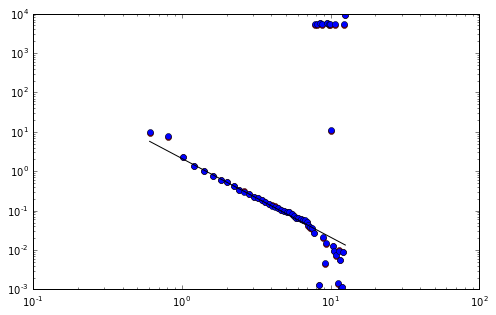

In [24]:
#Fitting with the "good" wave vectors to find the diffusion coefficient

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], tau[2:-1], 'ro')
ax.loglog(q[3:-1], ddm.newt(tau[2:-1],alph[2:-1]),'bo')



In [81]:
qmin = q[2]
qmax = q[10]
p = ddm.getDiff(tau[2:-1], q[3:-1], qmin, qmax)
ax.plot(q[3:-1], (1./p[0]) * 1.8/(q[3:-1]**2), '-k')

#first, import necessary modules for interactive capabilities
import ipywidgets as widgets
from ipywidgets import interact, fixed

def DiffCoef (StretchExp, StretchBG, qrange, qmin, qmax):
    nt = ddm.newt(StretchExp, StretchBG)
    indx = (qrange>qmin) & (qrange<qmax)
    ds = (qrange[indx]**-2) / nt[indx]
    return ds.mean()

def Diff_Fit(qrange, taurange, qmin, qmax, factor, StExp, StBG):
    step1 = ddm.getDiff(taurange, qrange, qmin, qmax)
    fit1 = (1./step1[0]) * factor/(qrange**2)
    step2 = DiffCoef(StExp, StBG, qrange, qmin, qmax)
    fit2 = (1./step2) * 1./(qrange**2)
    return fit1, fit2, step2
#Don't actually need the step1 part, just messing around with the getDiff line, but I the DiffCoef function works a lot better    
#Need to fix the function so the it will fit the data
#define a function to plot the results

def plot_results(alpha=1.8, qmin = q[2], qmax = q[10]):
    qs = q[3:-1]
    taus = tau[2:-1]
    fig,ax = plt.subplots(figsize=(8,8/1.618))
    plt.xlim((0.5,10))
    plt.ylim((0.005,40))
    ax.loglog(qs, tau[2:-1], 'ro')
    ax.loglog(qs, ddm.newt(taus ,alph [2:-1]),'bo')
    fits = Diff_Fit(qs,taus, qmin, qmax, alpha, alph[3:], bg[3:])
    ax.plot(qs, fits[0],  '-k')
    ax.plot(qs, fits[1], '-g')
    ax.text(0.55,0.8,'D = %.2f' % fits[2], 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes)


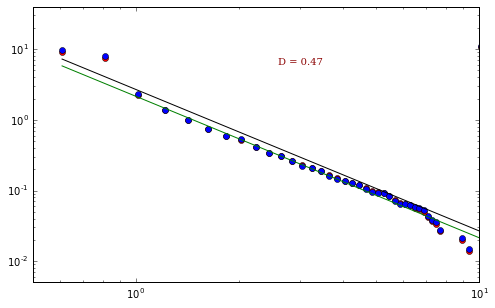

In [83]:

interact(plot_results, alpha=(0.5,2,0.05), qmin = (q[2], q[8]), qmax = (q[9], q[30]),  continuous_update=False)

In [123]:
#Some parameters...
kb = 1.38065e-23  #Boltzmann's constant
t = 294 #temperature in Kelvin
viscosity = 1.002e-3 # 1.002 mPa*s
diffusion_coeff = 0.48
radius = (kb*t)/(6*np.pi*viscosity*(diffusion_coeff*1e-12))
print "The radius is a = %.2f nm" % (radius*1e9)

The radius is a = 447.73 nm
